## 練習解答

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16()
model.summary()

2022-05-25 01:00:31.438282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-05-25 01:00:31.439024: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-25 01:00:31.439490: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
def load_imagenet_labels(labels_file):
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('data/ImageNetLabels.txt')

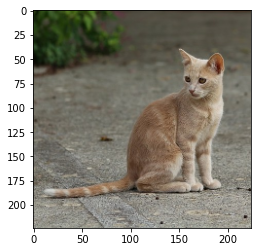

In [4]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
    return image

image = read_image('data/cat.jpeg')
plt.imshow(image/255)

In [5]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    inputs = preprocess_input(image_batch)
    predictions = model(inputs)
    top_probs, top_idxs = tf.math.top_k(input=predictions, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_idxs[0], top_probs[0]

In [6]:
pred_label, pred_idx, pred_prob = top_k_predictions(image)
for label, idx, prob in zip(pred_label, pred_idx, pred_prob):
    print(f'{label} ({idx}): {prob:0.1%}')

dingo (273): 26.1%
tiger cat (282): 24.0%
Egyptian cat (285): 17.7%


### 01_Perturbation-Based: 
 - Occlusion Sensitivity (Zeiler & Fergus 14): 
   1. 更改 patch_size 練習看看
   2. 更改不同的 target_class_idx 看看模型關注哪個地方

In [7]:
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    
    patched_image = np.array(image, copy=True)
    patched_image[
        top_left_y : top_left_y + patch_size, top_left_x : top_left_x + patch_size, :
    ] = 127.5

    return patched_image

In [8]:
def occlusion_sensitivity(image,
                          patch_size,
                          target_class_idx,
                          batch_size=16):
    
    sensitivity_map = np.zeros(
        (
            math.ceil(image.shape[0] / patch_size),
            math.ceil(image.shape[1] / patch_size),
        )
    )

    patches = [
        apply_grey_patch(image, top_left_x, top_left_y, patch_size)
        for index_x, top_left_x in enumerate(range(0, image.shape[0], patch_size))
        for index_y, top_left_y in enumerate(range(0, image.shape[1], patch_size))
    ]

    coordinates = [
        (index_y, index_x)
        for index_x in range(
            sensitivity_map.shape[1]  # pylint: disable=unsubscriptable-object
        )
        for index_y in range(
            sensitivity_map.shape[0]  # pylint: disable=unsubscriptable-object
        )
    ]
    
    inputs = preprocess_input(np.array(patches))
    predictions = model.predict(inputs, batch_size=batch_size)

    target_class_probs = [
        prob[target_class_idx] for prob in predictions
    ]
    
    for (index_y, index_x), confidence in zip(
        coordinates, target_class_probs
    ):
        sensitivity_map[index_y, index_x] = 1 - confidence

    sensitivity_maps = cv2.resize(sensitivity_map, tuple(image.shape[0:2]))

    return sensitivity_maps

### target class index = dingo (273): 26.1%

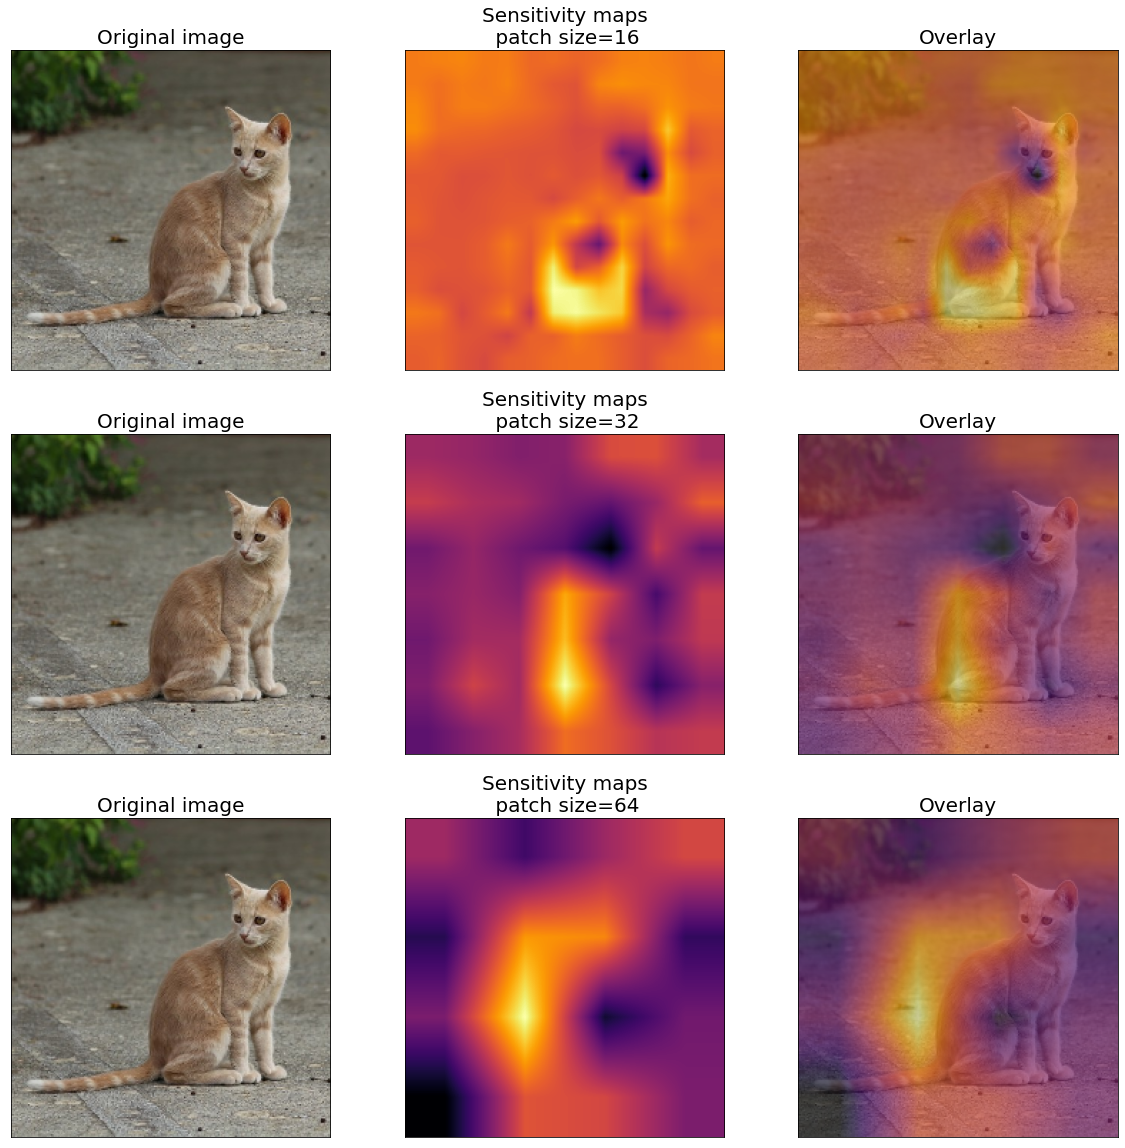

In [9]:
patch_sizes = [16, 32, 64] 

fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(20, 20),
                        subplot_kw={'xticks':[], 'yticks':[]})

for i, patch_size in enumerate(patch_sizes):
    
    axs[i, 0].set_title('Original image', fontsize=20)
    axs[i, 0].imshow(image/255)
    
    sensitivity_maps = occlusion_sensitivity(image, patch_size, target_class_idx=273, batch_size=16)
    
    axs[i, 1].set_title(f'Sensitivity maps\n patch size={patch_size}', fontsize=20)
    axs[i, 1].imshow(sensitivity_maps, cmap=cm.inferno)

    axs[i, 2].set_title(f'Overlay', fontsize=20)
    axs[i, 2].imshow(sensitivity_maps, cmap=cm.inferno)
    axs[i, 2].imshow(image/255, alpha=0.4)

### target class index = tiger cat (282): 24.0%

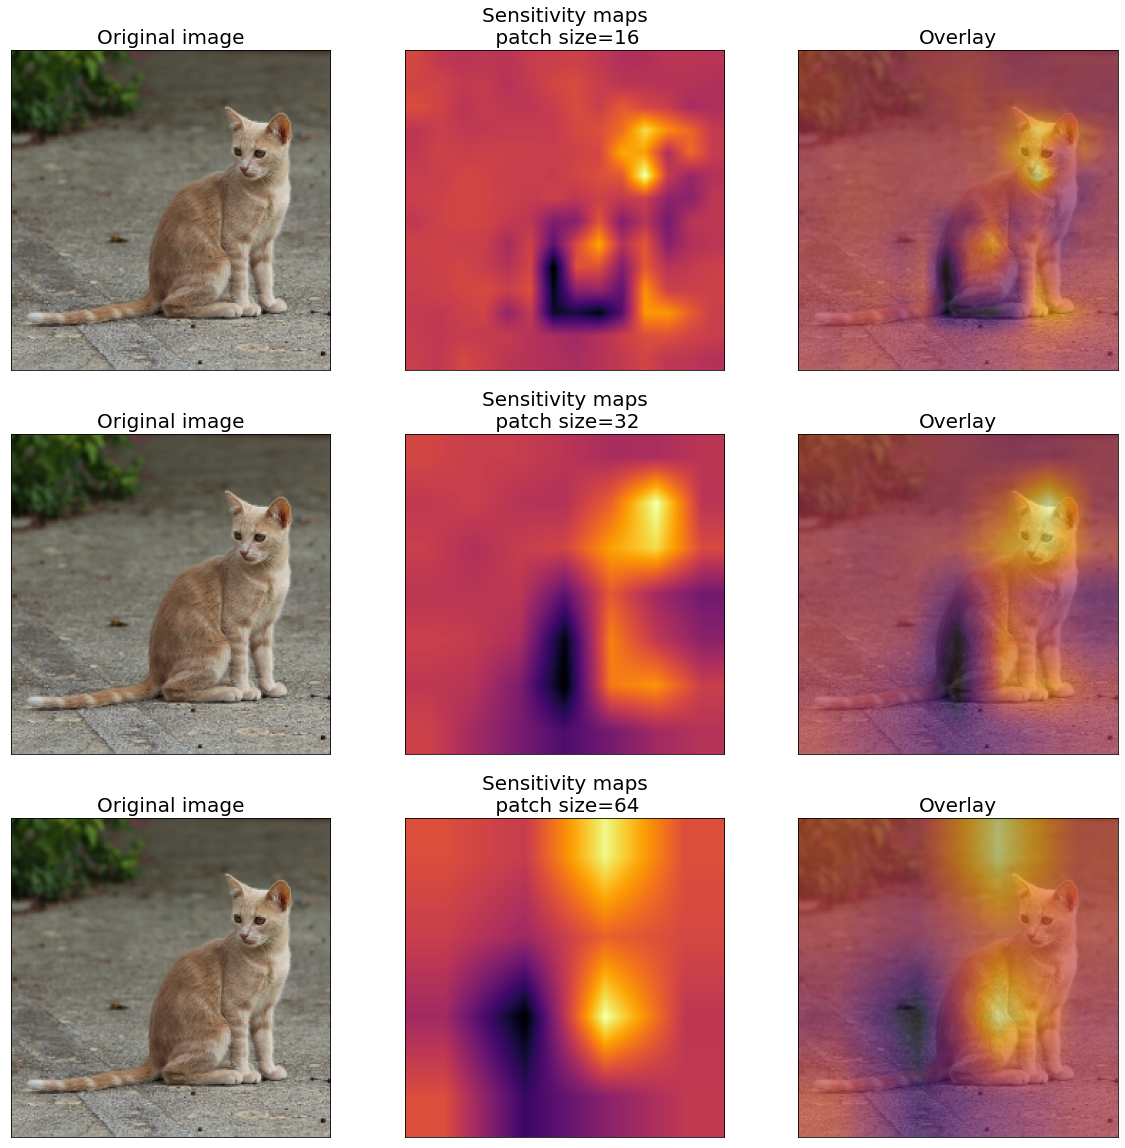

In [10]:
patch_sizes = [16, 32, 64] 

fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(20, 20),
                        subplot_kw={'xticks':[], 'yticks':[]})

for i, patch_size in enumerate(patch_sizes):
    
    axs[i, 0].set_title('Original image', fontsize=20)
    axs[i, 0].imshow(image/255)
    
    sensitivity_maps = occlusion_sensitivity(image, patch_size, target_class_idx=282, batch_size=16)
    
    axs[i, 1].set_title(f'Sensitivity maps\n patch size={patch_size}', fontsize=20)
    axs[i, 1].imshow(sensitivity_maps, cmap=cm.inferno)

    axs[i, 2].set_title(f'Overlay', fontsize=20)
    axs[i, 2].imshow(sensitivity_maps, cmap=cm.inferno)
    axs[i, 2].imshow(image/255, alpha=0.4)

### 02_Gradient-Based: 
1. Sensitivity Analysis (Simonyan et al. 14): 更換 target_class_idx，看梯度有沒有關注在不同的地方。
2. SmoothGrad (Smikov et al. 17): 更換 num sample，看是不是越多 sample 噪音越少。
3. Integrated Gradients (Sundararajan et al. 17): 調整看看 m_steps，看看是不是越多解釋性越穩定。

In [11]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

#### 1. Sensitivity Analysis (Simonyan et al. 14): 更換 target_class_idx，看梯度有沒有關注在不同的地方。
- dingo (273): 26.1%
- tiger cat (282): 24.0%
- Egyptian cat (285): 17.7%

In [12]:
@tf.function
def vanilla_gradients(image,
                      target_class_idx):
    image_batch = tf.expand_dims(image, 0)
    inputs = preprocess_input(image_batch)
    gradients = compute_gradients(
        images=inputs,
        target_class_idx=target_class_idx)

    return tf.squeeze(gradients)

### target class index = dingo (273): 26.1%

In [13]:
vg_attributions = vanilla_gradients(image=image,
                                    target_class_idx=273)

attribution_mask = tf.reduce_sum(tf.math.abs(vg_attributions), axis=-1)

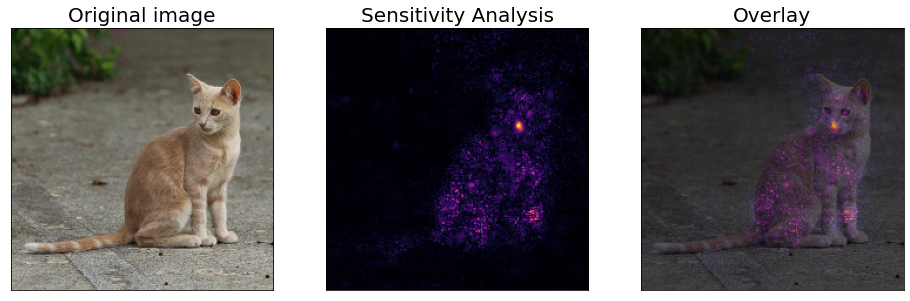

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity Analysis', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

### target class index = tiger cat (282): 24.0%

In [15]:
vg_attributions = vanilla_gradients(image=image,
                                    target_class_idx=282)

attribution_mask = tf.reduce_sum(tf.math.abs(vg_attributions), axis=-1)

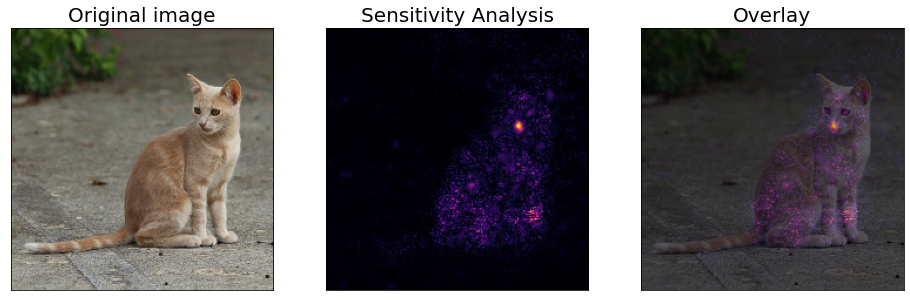

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity Analysis', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

#### 2. SmoothGrad (Smikov et al. 17): 更換 num sample，看是不是越多 sample 噪音越少。

In [17]:
def generate_noisy_images(images, num_samples, noise):
    repeated_images = tf.repeat(images, num_samples, axis=0)
    noise = np.random.normal(0, noise, repeated_images.shape).astype(np.float32)
    return tf.clip_by_value(repeated_images + noise, 0, 255)

In [18]:
@tf.function
def smooth_gradients(image,
                     target_class_idx,
                     num_samples,
                     noise=1):
    
    image_batch = tf.expand_dims(image, 0)
    noisy_images = generate_noisy_images(image_batch, num_samples, noise)
    inputs = preprocess_input(noisy_images)

    gradients = compute_gradients(
        images=inputs,
        target_class_idx=target_class_idx)

    averaged_grads = tf.reduce_mean(gradients, axis=0)

    return tf.squeeze(averaged_grads)

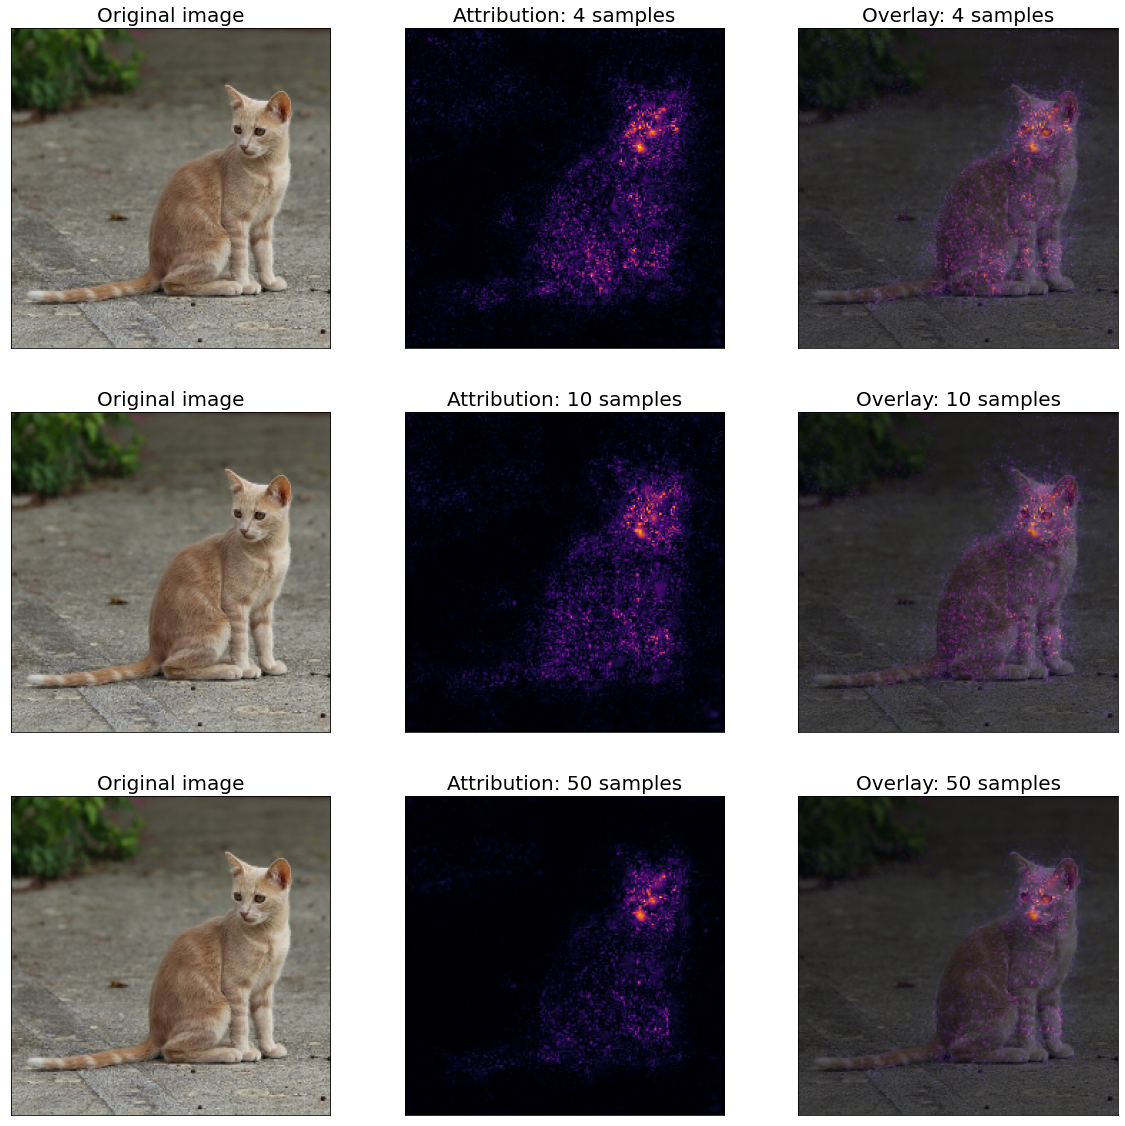

In [19]:
num_samples = [4, 10, 50] 

fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(20, 20),
                        subplot_kw={'xticks':[], 'yticks':[]})

for i, num_sample in enumerate(num_samples):
    
    axs[i, 0].set_title('Original image', fontsize=20)
    axs[i, 0].imshow(image/255)
    
    averaged_grads = smooth_gradients(image, 273, num_sample, noise=25)
    attribution_mask = tf.reduce_sum(tf.math.abs(averaged_grads), axis=-1)
    
    axs[i, 1].set_title(f'Attribution: {num_sample} samples', fontsize=20)
    axs[i, 1].imshow(attribution_mask, cmap=cm.inferno)

    axs[i, 2].set_title(f'Overlay: {num_sample} samples', fontsize=20)
    axs[i, 2].imshow(attribution_mask, cmap=cm.inferno)
    axs[i, 2].imshow(image/255, alpha=0.4)

#### 3. Integrated Gradients (Sundararajan et al. 17): 調整看看 m_steps，

In [20]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images

In [21]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [22]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        # 2. Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                           image=image,
                                                           alphas=alpha_batch)

        # 3. Compute gradients between model outputs and interpolated inputs.
        inputs = preprocess_input(interpolated_path_input_batch)
        gradient_batch = compute_gradients(images=inputs,
                                           target_class_idx=target_class_idx)
        
        # Write batch indices and gradients to extend TensorArray.
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()

    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # 5. Scale integrated gradients with respect to input. 
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [23]:
baseline = tf.zeros(shape=(224,224,3))
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=image,
                                       target_class_idx=554,
                                       m_steps=240)

attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

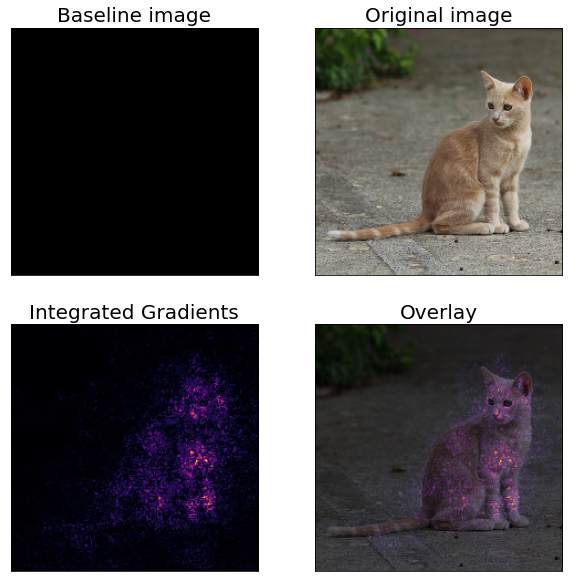

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(10, 10),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Baseline image', fontsize=20)
axs[0, 0].imshow(baseline)

axs[0, 1].set_title('Original image', fontsize=20)
axs[0, 1].imshow(image/255)

axs[1, 0].set_title('Integrated Gradients', fontsize=20)
axs[1, 0].imshow(attribution_mask, cmap=cm.inferno)

axs[1, 1].set_title('Overlay', fontsize=20)
axs[1, 1].imshow(attribution_mask, cmap=cm.inferno)
axs[1, 1].imshow(image/255, alpha=0.4)

In [25]:
baseline = tf.zeros(shape=(224,224,3))
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=image,
                                       target_class_idx=554,
                                       m_steps=240)

attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

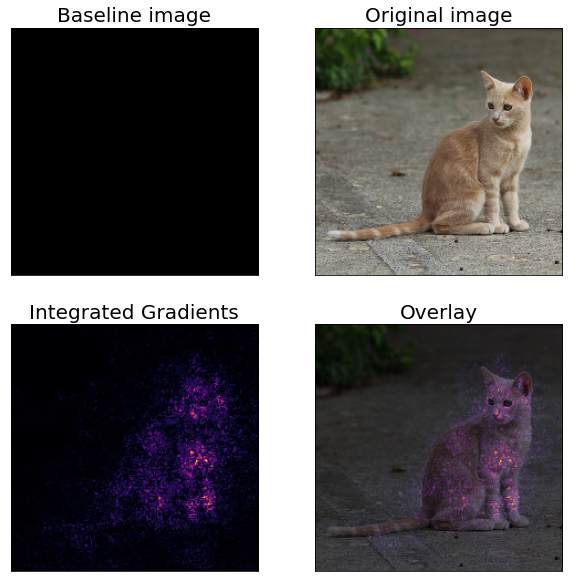

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(10, 10),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Baseline image', fontsize=20)
axs[0, 0].imshow(baseline)

axs[0, 1].set_title('Original image', fontsize=20)
axs[0, 1].imshow(image/255)

axs[1, 0].set_title('Integrated Gradients', fontsize=20)
axs[1, 0].imshow(attribution_mask, cmap=cm.inferno)

axs[1, 1].set_title('Overlay', fontsize=20)
axs[1, 1].imshow(attribution_mask, cmap=cm.inferno)
axs[1, 1].imshow(image/255, alpha=0.4)

### 02_Propagation-Based: 
- LRP (Bach et al. 15)

In [27]:
import tensorflow.keras.backend as K
from tensorflow.python.ops import gen_nn_ops

def relprop_dense(x, w, r):
    w_pos = tf.maximum(w, 0.0)
    z = tf.matmul(x, w_pos) + 1.0e-9
    s = r / z
    c = tf.matmul(s, tf.transpose(w_pos))
    return c * x

def relprop_flatten(x, r):
    return tf.reshape(r, tf.shape(x))

def relprop_conv(x, w, r, name, strides=(1, 1, 1, 1), padding='SAME'):
    if name == 'block1_conv1':
        x = tf.ones_like(x)     # only for input

    w_pos = tf.maximum(w, 0.0)
    z = tf.nn.conv2d(x, w_pos, strides, padding) + 1.0e-9
    s = r / z
    c = tf.compat.v1.nn.conv2d_backprop_input(tf.shape(x), w_pos, s, strides, padding)
    return c * x

In [28]:
def rescale(x):
    x_min = np.min(x, axis=(1, 2), keepdims=True)
    x_max = np.max(x, axis=(1, 2), keepdims=True)
    return (x - x_min).astype("float64") / (x_max - x_min).astype("float64")

In [29]:
def lrp(image, model):

    weights = {weight.name.split('/')[0]: weight for weight in model.trainable_weights if 'bias' not in weight.name}
    activations = [layer.output for layer in model.layers]
    activations = activations[::-1]
    layer_names = [layer.name for layer in model.layers]
    layer_names = layer_names[::-1]
    
    relevance = model.output
    for i, layer_name in enumerate(layer_names):
        if 'prediction' in layer_name:
            relevance = relprop_dense(activations[i+1], weights[layer_name], relevance)
        elif 'fc' in layer_name:
            relevance = relprop_dense(activations[i+1], weights[layer_name], relevance)
        elif 'flatten' in layer_name:
            relevance = relprop_flatten(activations[i+1], relevance)
        elif 'pool' in layer_name:
            relevance = tf.keras.layers.UpSampling2D(size=(2,2))(relevance)
        elif 'conv' in layer_name:
            relevance = relprop_conv(activations[i+1], weights[layer_name], relevance, layer_name)
        elif 'input' in layer_name:
            pass
        else:
            raise Exception("Error: layer type not recognized.")
            
    f = K.function(inputs=model.input, outputs=relevance)
    
    image_batch = tf.expand_dims(image, 0)
    inputs = preprocess_input(image_batch)
    relevance_scores = f(inputs)

    return relevance_scores

In [30]:
relevance_scores = lrp(image, model)
attribution_mask = tf.reduce_sum(tf.math.abs(tf.squeeze(rescale(relevance_scores))), axis=-1)

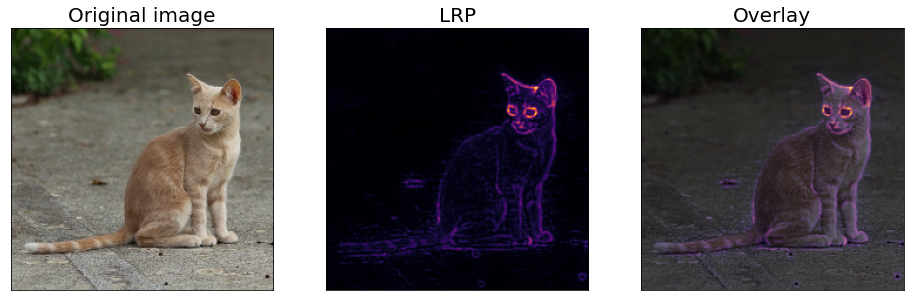

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('LRP', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

## 04_CAM-Based
1. Grad-CAM (Ancona et al. 16)
2. Layer-CAM (Peng-Tao et al. 21)

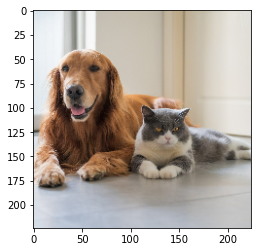

In [32]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
    return image

image = read_image('data/cat_and_dog.jpg')
plt.imshow(image/255)

In [33]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    inputs = preprocess_input(image_batch)
    predictions = model(inputs)
    top_probs, top_idxs = tf.math.top_k(input=predictions, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_idxs[0], top_probs[0]

In [34]:
pred_label, pred_idx, pred_prob = top_k_predictions(image)
for label, idx, prob in zip(pred_label, pred_idx, pred_prob):
    print(f'{label} ({idx}): {prob:0.1%}')

golden retriever (207): 29.2%
Irish setter (213): 3.0%
redbone (168): 2.5%


### 1. Grad-CAM (Ancona et al. 16)

In [35]:
def infer_target_layer(model):

    for layer in reversed(model.layers):
        # Select closest 4D layer to the end of the network.
        if len(layer.output_shape) == 4:
            return layer.name

    raise ValueError(
        "Model does not seem to contain 4D layer. CAM-Based method cannot be applied."
    )

In [36]:
def gradcam(image,
            model,
            layer_name=None,
            target_class_idx=None):
    
    image_batch = tf.expand_dims(image, 0)
    inputs = preprocess_input(image_batch)
    if layer_name is None:
        layer_name = infer_target_layer(model)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(inputs)
        if target_class_idx is None:
            target_class_idx = tf.argmax(preds[0])
        class_channel = preds[:, target_class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap

### target class index = golden retriever (207)

In [37]:
heatmap = gradcam(image, model, target_class_idx=207)
heatmap_3dim = tf.expand_dims(heatmap, axis=2)
attribution_mask = tf.squeeze(tf.image.resize(heatmap_3dim, size=(image.shape[1], image.shape[0])))

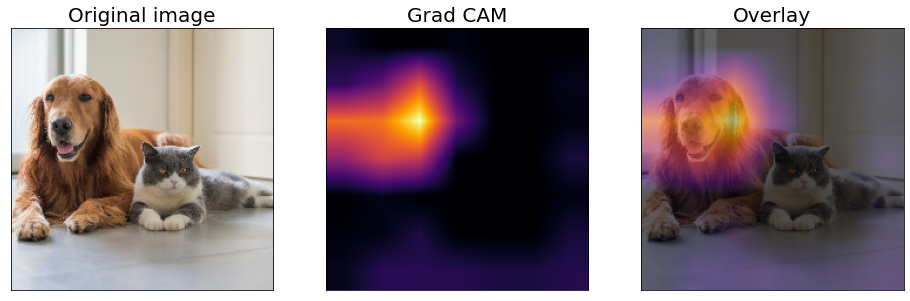

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Grad CAM', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

### target class index = Persian cat (284)

In [39]:
heatmap = gradcam(image, model, target_class_idx=284)
heatmap_3dim = tf.expand_dims(heatmap, axis=2)
attribution_mask = tf.squeeze(tf.image.resize(heatmap_3dim, size=(image.shape[1], image.shape[0])))

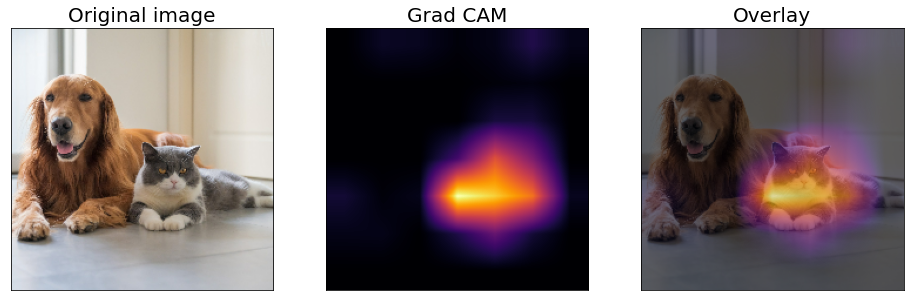

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Grad CAM', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

### 2. Layer-CAM (Peng-Tao et al. 21)

In [46]:
def layercam(image,
             model,
             layer_names,
             target_class_idx):
    # Generate class activation heatmap
    heatmaps = []
    for layer_name in layer_names:
        heatmap = gradcam(image, model, layer_name, target_class_idx)
        heatmaps.append(heatmap)
    
    hm_out = np.zeros((28, 28))
    for hm in heatmaps:
        hm_out += cv2.resize(hm.numpy(), (28, 28))
    hm_out /= tf.math.reduce_max(hm_out)
    return hm_out

### target class index = golden retriever (207)

In [47]:
layer_names = ['block5_pool', 'block4_pool', 'block3_pool']
heatmap = layercam(image, model, layer_names, target_class_idx=207)
heatmap_3dim = tf.expand_dims(heatmap, axis=2)
attribution_mask = tf.squeeze(tf.image.resize(heatmap_3dim, size=(image.shape[1], image.shape[0])))

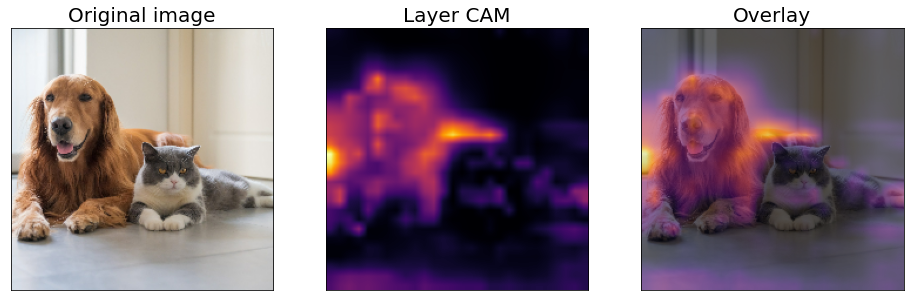

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Layer CAM', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

### target class index = Persian cat (284)

In [49]:
layer_names = ['block5_pool', 'block4_pool', 'block3_pool']
heatmap = layercam(image, model, layer_names, target_class_idx=284)
heatmap_3dim = tf.expand_dims(heatmap, axis=2)
attribution_mask = tf.squeeze(tf.image.resize(heatmap_3dim, size=(image.shape[1], image.shape[0])))

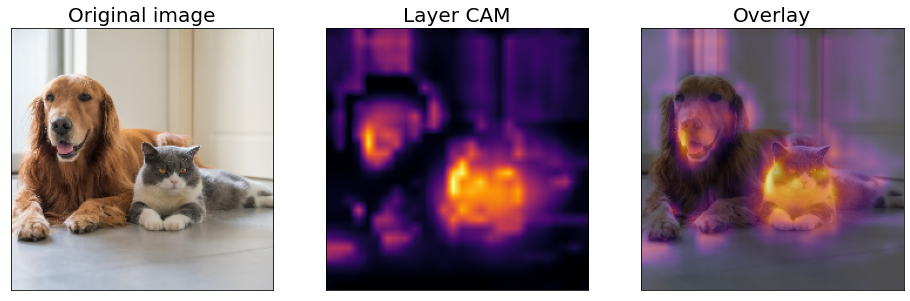

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Layer CAM', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)